In [1]:
import os

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
file_name = 'df_noisy_out_census_dp_rho=2.65.csv'
df = pd.read_csv(f'out/{file_name}')
error = df['avg_noisy_basic_alloc'] - df['calculated_basic_alloc']

print(error.sum())
df.head()

-8.244969649240375e-07


,State FIPS Code,District ID,State,Name,basic_alloc,targeted_alloc,concentration_alloc,official_population_count,official_children_count,official_children_formula_count,...,cv,sppe,avg_noisy_basic_alloc,avg_noisy_concentration_alloc,avg_noisy_target_alloc,avg_noisy_children_formula_count,avg_noisy_children_count,calculated_basic_alloc,calculated_concentrated_alloc,calculated_targeted_alloc
0,1,190,ALABAMA,Alabaster City School District,404482.451481,159746.293284,0.000000,34669.0,6710.0,673.0,...,0.23,9697.0,417994.777133,0.000000,168241.609322,673.0445,6709.9694,417981.280355,0.000000,168414.128080
1,1,5,ALABAMA,Albertville City School District,738438.215814,498231.293705,180752.421632,22051.0,4131.0,970.0,...,0.23,9697.0,602460.866994,167023.178714,314086.983322,970.0671,4130.6994,602439.586842,167239.580002,314624.010751
2,1,30,ALABAMA,Alexander City City School District,493947.426734,353662.302968,122103.107993,16920.0,2575.0,708.0,...,0.28,9697.0,439717.320292,121904.911224,260319.646557,708.0216,2574.6963,439718.791221,122067.652208,260782.114101
3,1,60,ALABAMA,Andalusia City School District,245814.743916,144408.067790,62375.463078,8842.0,1465.0,409.0,...,0.35,9697.0,254086.571790,70441.693474,152065.311005,409.1237,1465.0357,254018.341256,70516.482702,152243.650382
4,1,90,ALABAMA,Anniston City School District,662918.490317,510408.966121,168215.490893,22043.0,2957.0,1103.0,...,0.23,9697.0,684816.237928,189854.834321,519308.413587,1102.6736,2957.0657,685042.128131,190170.367776,520508.918499


In [3]:
df['avg_noisy_concentrated_alloc'] = df['avg_noisy_concentration_alloc']
df['avg_noisy_targeted_alloc'] = df['avg_noisy_target_alloc']

df['basic_error']= df['avg_noisy_basic_alloc'] - df['calculated_basic_alloc']
df['concentrated_error']= df['avg_noisy_concentrated_alloc'] - df['calculated_concentrated_alloc']
df['targeted_error']= df['avg_noisy_target_alloc'] - df['calculated_targeted_alloc']

df['calculated_total_alloc'] = df['calculated_basic_alloc'] + df['calculated_concentrated_alloc'] + df[
    'calculated_targeted_alloc']

df['avg_noisy_total_alloc'] = df['avg_noisy_basic_alloc'] + df['avg_noisy_concentrated_alloc'] + df[
    'avg_noisy_targeted_alloc']

df['official_children_formula_proportion'] = df['official_children_formula_count'] / df['official_children_count']
df['noisy_children_formula_proportion'] = df['avg_noisy_children_formula_count'] / df['avg_noisy_children_count']
df['total_alloc_error'] = df['avg_noisy_total_alloc'] - df['calculated_total_alloc']
df['total_alloc_error_per_student'] = df['total_alloc_error'] / df['official_children_formula_count']
df[['official_children_formula_proportion', 'official_children_formula_count', 'official_children_count',
    'total_alloc_error']]
df

,State FIPS Code,District ID,State,Name,basic_alloc,targeted_alloc,concentration_alloc,official_population_count,official_children_count,official_children_formula_count,...,avg_noisy_targeted_alloc,basic_error,concentrated_error,targeted_error,calculated_total_alloc,avg_noisy_total_alloc,official_children_formula_proportion,noisy_children_formula_proportion,total_alloc_error,total_alloc_error_per_student
0,1,190,ALABAMA,Alabaster City School District,404482.451481,159746.293284,0.000000,34669.0,6710.0,673.0,...,168241.609322,13.496778,0.000000,-172.518758,5.863954e+05,5.862364e+05,0.100298,0.100305,-159.021980,-0.236288
1,1,5,ALABAMA,Albertville City School District,738438.215814,498231.293705,180752.421632,22051.0,4131.0,970.0,...,314086.983322,21.280152,-216.401289,-537.027429,1.084303e+06,1.083571e+06,0.234810,0.234843,-732.148565,-0.754792
2,1,30,ALABAMA,Alexander City City School District,493947.426734,353662.302968,122103.107993,16920.0,2575.0,708.0,...,260319.646557,-1.470929,-162.740984,-462.467544,8.225686e+05,8.219419e+05,0.274951,0.274992,-626.679457,-0.885140
3,1,60,ALABAMA,Andalusia City School District,245814.743916,144408.067790,62375.463078,8842.0,1465.0,409.0,...,152065.311005,68.230534,-74.789228,-178.339378,4.767785e+05,4.765936e+05,0.279181,0.279259,-184.898072,-0.452074
4,1,90,ALABAMA,Anniston City School District,662918.490317,510408.966121,168215.490893,22043.0,2957.0,1103.0,...,519308.413587,-225.890203,-315.533454,-1200.504913,1.395721e+06,1.393979e+06,0.373013,0.372895,-1741.928570,-1.579264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13185,56,4260,WYOMING,Uinta County School District 6,38820.977975,0.000000,0.000000,3110.0,736.0,29.0,...,5463.598977,-1109.216031,0.000000,5463.598977,2.701664e+04,3.137103e+04,0.039402,0.039691,4354.382946,150.151136
13186,56,6240,WYOMING,Washakie County School District 1,202136.816352,143772.433187,0.000000,7135.0,1295.0,151.0,...,56581.934155,16.772882,255.767827,-98.349612,1.973531e+05,1.975273e+05,0.116602,0.116633,174.191098,1.153583
13187,56,5820,WYOMING,Washakie County School District 2,16063.852955,11425.623829,0.000000,670.0,90.0,12.0,...,7798.654698,542.823178,2981.129838,3294.261286,1.568369e+04,2.250191e+04,0.133333,0.158352,6818.214303,568.184525
13188,56,4830,WYOMING,Weston County School District 1,167331.801616,121804.498990,94649.354236,5465.0,816.0,125.0,...,48112.271371,-466.656327,-12903.422426,1191.506663,1.956991e+05,1.835205e+05,0.153186,0.152630,-12178.572090,-97.428577


In [4]:
basic_error = df['avg_noisy_basic_alloc'] - df['calculated_basic_alloc']
conc_error = df['avg_noisy_concentration_alloc'] - df['calculated_concentrated_alloc']
targ_error = df['avg_noisy_target_alloc'] - df['calculated_targeted_alloc']

print('basic_error', basic_error.sum())
print('conc_error', conc_error.sum())
print('targeted_error', targ_error.sum())

basic_error -8.244969649240375e-07
conc_error 7.121707312762737e-08
targeted_error 1.2957025319337845e-07


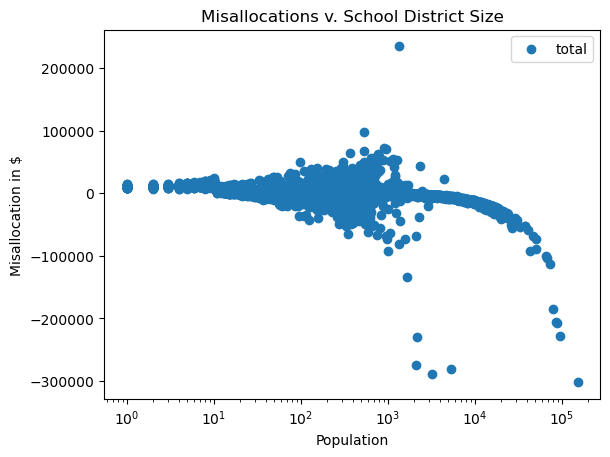

In [5]:
def plot_misallocations_over_all_states(allocs):
    for alloc in allocs:
        errors = (df[f'avg_noisy_{alloc}_alloc'] - df[f'calculated_{alloc}_alloc'])
        plt.scatter(df['official_children_formula_count'], errors, label=alloc)

    plt.title('Misallocations v. School District Size')
    plt.xlabel('Population')
    plt.ylabel('Misallocation in $')
    plt.xscale('log')
    plt.legend()
    plt.show()


# plot_misallocations_over_all_states(['basic', 'concentrated', 'targeted'])
plot_misallocations_over_all_states(['total'])


(13190,)


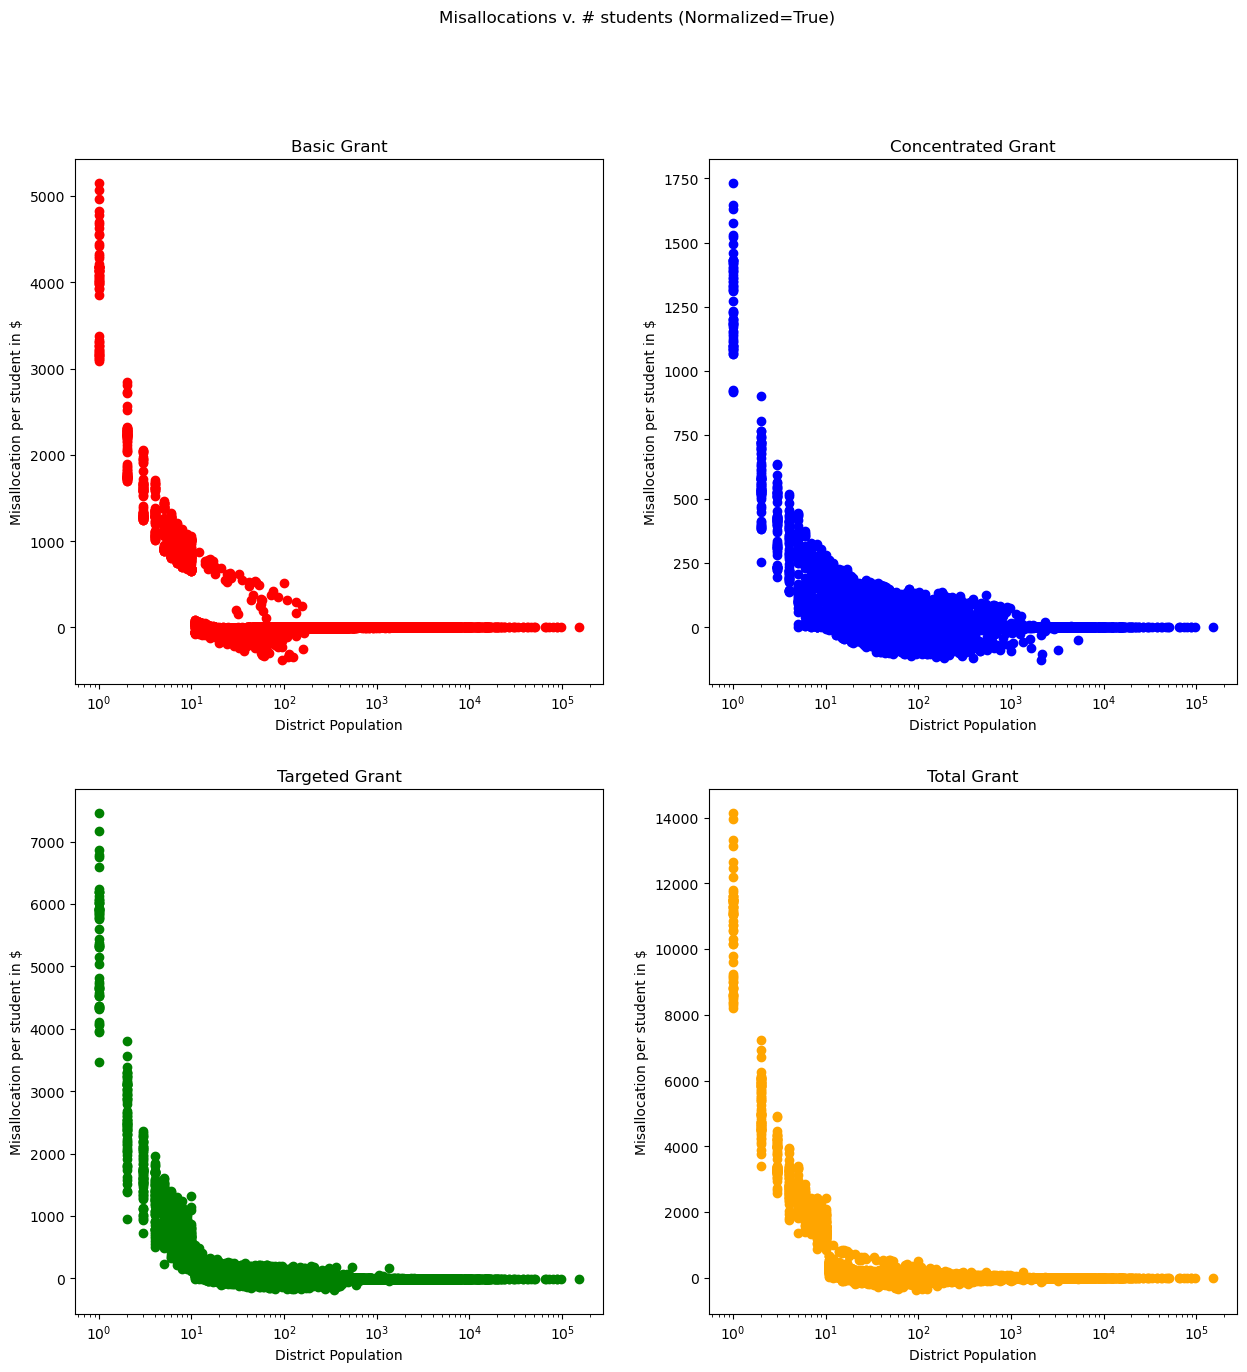

In [6]:
# misallocations per capita
# x_axis = df['official_children_formula_count'] / df['official_children_count']
x_axis = df['official_children_formula_count']

def plot_per_capita_misallocations_over_all_states(alloc, normalized=False, ax=None, color=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    errors = df[f'avg_noisy_{alloc}_alloc'] - df[f'calculated_{alloc}_alloc']
    if normalized:
        errors = errors / df['official_children_formula_count']
    ax.scatter(x_axis, errors, color=color)

    ax.set_title(f'{alloc.capitalize()} Grant')
    ax.set_xlabel('District Population')
    ax.set_ylabel('Misallocation per student in $')
    ax.set_xscale('log')
    # ax.set_xlim(0, 0.8)
    # ax.legend()


# plot_misallocations_over_all_states(['basic', 'concentrated', 'targeted'])
normalized = True
# make 4 figure plot
keys = ["basic", "concentrated", "targeted", "total"]
colors = ["red", "blue", "green", "orange"]

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i, key in enumerate(keys):
    plot_per_capita_misallocations_over_all_states(key, normalized=normalized, ax=axs[i // 2, i % 2], color=colors[i])

fig.suptitle(f'Misallocations v. # students (Normalized={normalized})')

# number of total schools
print(df['official_children_count'].shape)



/Users/pranavputta/miniconda3/envs/titlei_fund_allocation/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


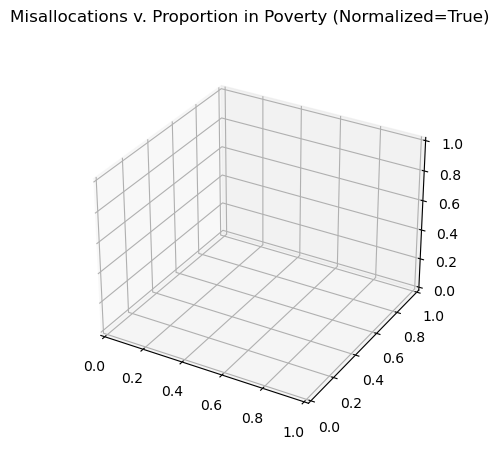

(13190,)


In [7]:
# misallocations per capita
x_axis = df['official_children_formula_count'] / df['official_children_count']
y_axis = df['official_children_count']
# x_axis = df['official_children_count']

def plot_per_capita_misallocations_over_all_states(alloc, normalized=False, ax=None, color=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    errors = df[f'avg_noisy_{alloc}_alloc'] - df[f'calculated_{alloc}_alloc']
    if normalized:
        errors = errors / df['official_children_formula_count']
    ax.scatter(x_axis, y_axis, errors, color=color)

    ax.set_title(f'{alloc.capitalize()} Grant')
    ax.set_xlabel('# of children')
    ax.set_ylabel('Misallocation in $')
    # ax.set_xscale('log')
    # ax.set_xlim(0, 0.8)
    # ax.legend()


# plot_misallocations_over_all_states(['basic', 'concentrated', 'targeted'])
normalized = True
# make 4 figure plot
keys = ["basic", "concentrated", "targeted", "total"]
colors = ["red", "blue", "green", "orange"]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_per_capita_misallocations_over_all_states(key, normalized=normalized, ax=axs[i // 2, i % 2], color=colors[i])

fig.suptitle(f'Misallocations v. Proportion in Poverty (Normalized={normalized})')
plt.show()

# number of total schools
print(df['official_children_count'].shape)



In [20]:
df['official_children_formula_count'].sort_values()

767           0.0
4482          0.0
4402          0.0
345           0.0
7654          0.0
           ...   
10548     79787.0
2452      87467.0
8591      88475.0
8592      96647.0
1106     152946.0
Name: official_children_formula_count, Length: 13190, dtype: float64

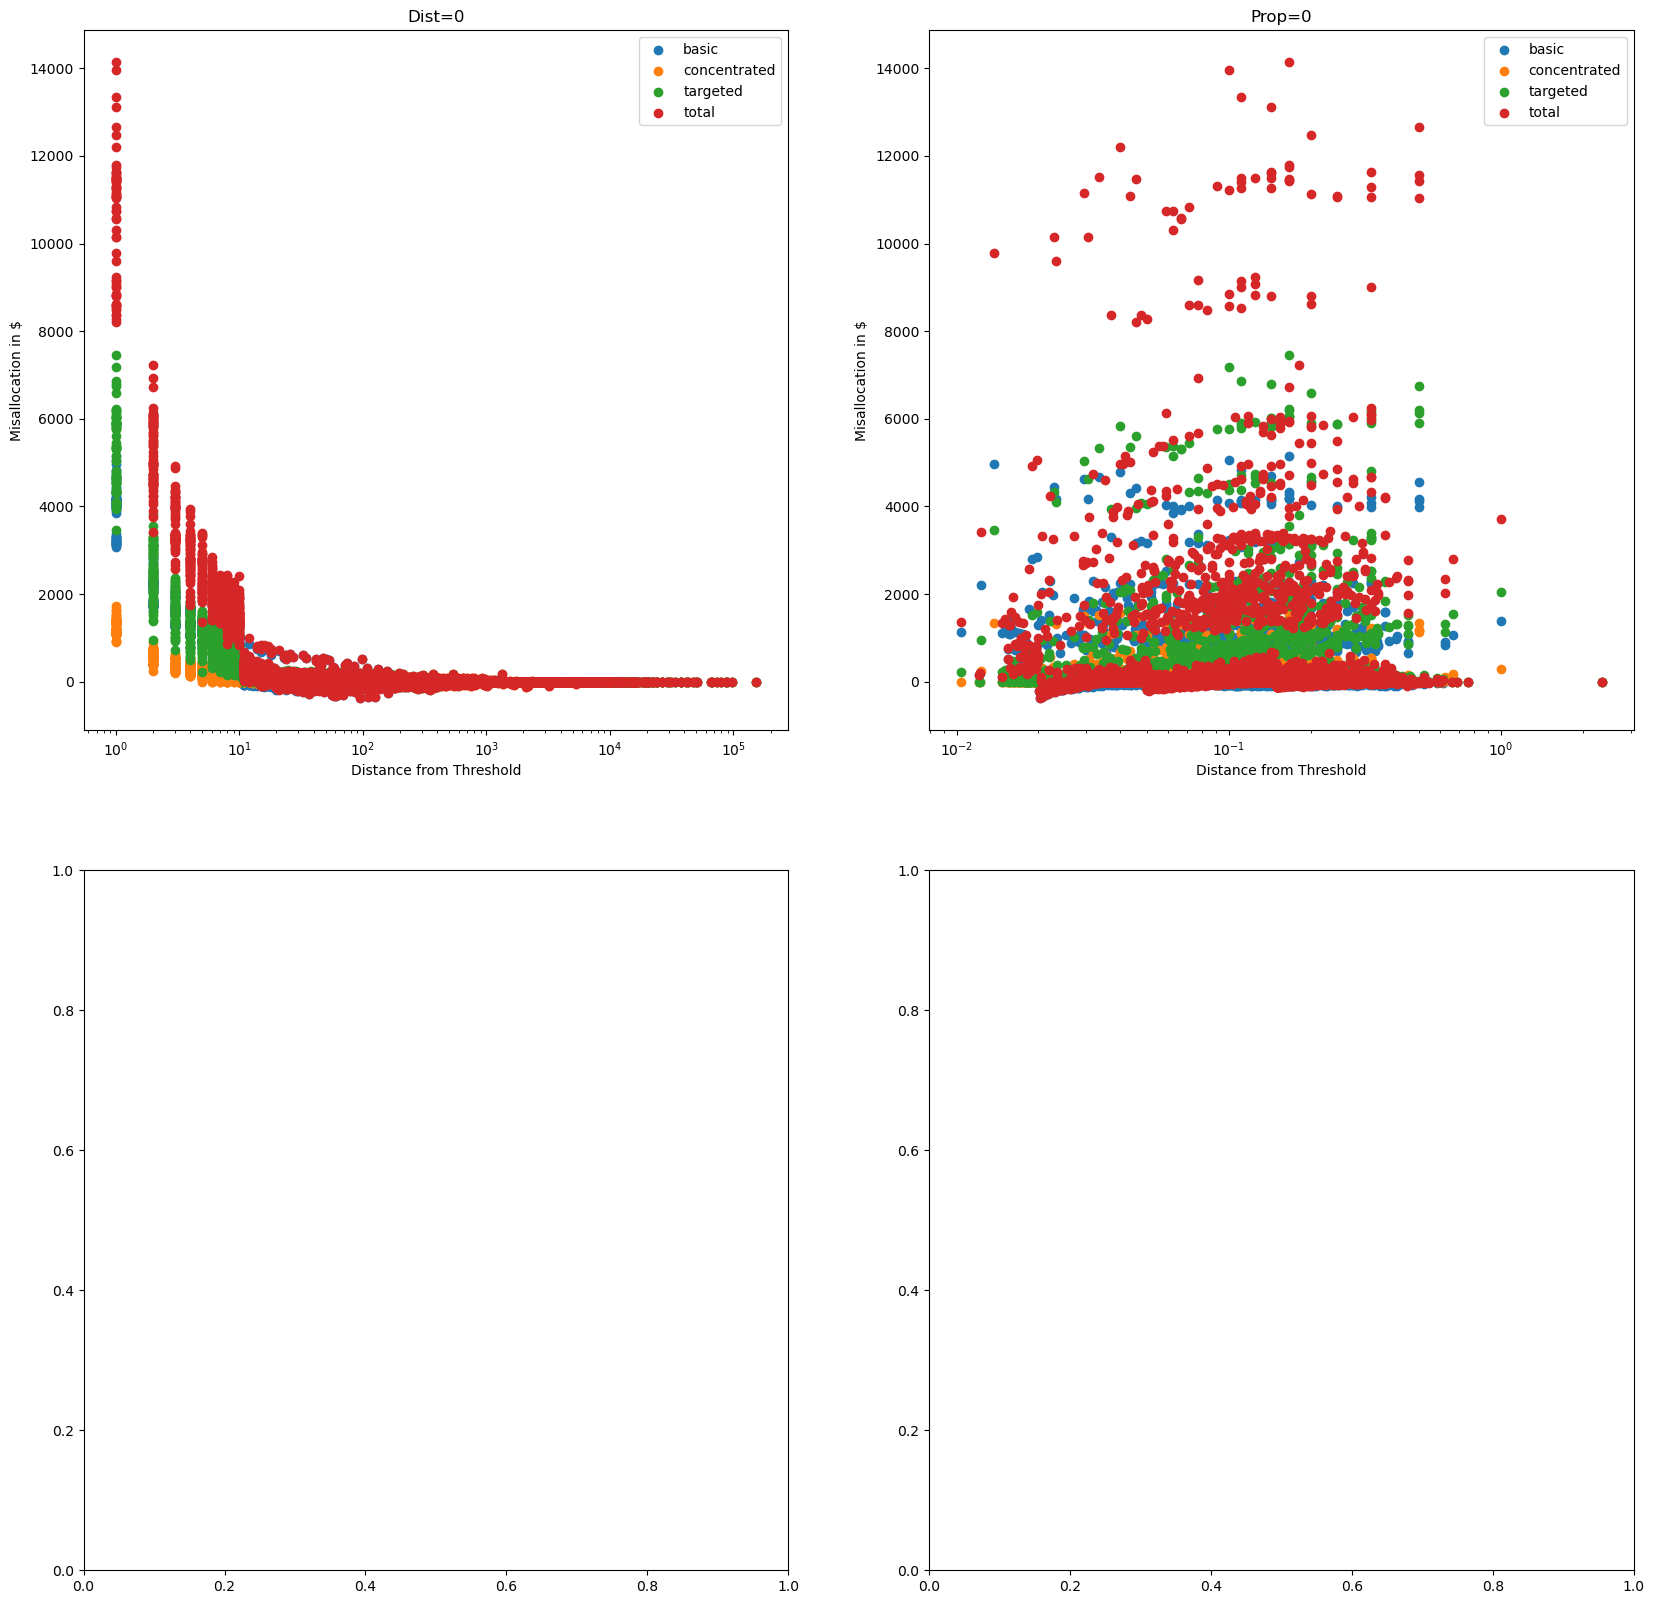

In [11]:
# misallocations v. distance from threshold
def misallocations_by_distance_from_threshold(allocs, ax, count_threshold=None, prop_threshold=None, normalized=False,
                                              title=None, log_scale=False):
    for alloc in allocs:
        errors = (df[f'avg_noisy_{alloc}_alloc'] - df[f'calculated_{alloc}_alloc'])
        if normalized:
            errors = errors / df['official_children_formula_count']

        if count_threshold is not None:
            x = df['official_children_formula_count']
            x = np.abs(x - count_threshold)
            ax.set_xscale('log')
        elif prop_threshold is not None:
            x = df['official_children_formula_count'] / df['official_children_count']
            x = np.abs(x - prop_threshold)

        ax.scatter(x, errors, label=alloc)

    ax.set_title(title)
    ax.set_xlabel('Distance from Threshold')
    ax.set_ylabel('Misallocation in $')
    if log_scale:
        ax.set_xscale('log')
    # ax.set_xlim(0, 0.2)
    ax.legend()


normalized = True
allocs = ['basic', 'concentrated', 'targeted', 'total']
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
misallocations_by_distance_from_threshold(allocs, axs[0, 0], count_threshold=0, title='Dist=0', normalized=normalized)
misallocations_by_distance_from_threshold(allocs, axs[0, 1], prop_threshold=0., title='Prop=0', normalized=normalized,
                                          log_scale=True)
#plt.title(f'Misallocations v. Dist from Threshold (Normalized={normalized})')


In [9]:
# Misallocations per State
df_grp_states = df.groupby('State FIPS Code')


def save_misallocs_per_state_graphs(allocs):
    for key in df_grp_states.groups.keys():
        df_state = df.loc[df_grp_states.groups[key]]
        state = df_state['State'].values[0]

        for alloc in allocs:
            errors = df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc']

            # plt.scatter(df_state['official_children_count'], errors, label='total children pop')
            plt.scatter(df_state['official_children_formula_count'], errors, label=alloc)

        plt.title(state)
        plt.xlabel('Population')
        plt.ylabel('Misallocation in $')

        plt.xscale('log')

        save_loc = f'../out/plots/{file_name}/{state}.png'
        os.makedirs(os.path.dirname(save_loc), exist_ok=True)
        plt.legend()
        plt.savefig(save_loc)
        plt.clf()


save_misallocs_per_state_graphs(['basic', 'concentrated', 'targeted'])

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fed58dabf40> (for post_execute):


IndexError: list index out of range

IndexError: list index out of range

<Figure size 640x480 with 1 Axes>

AttributeError: 'SeriesGroupBy' object has no attribute 'argmax'

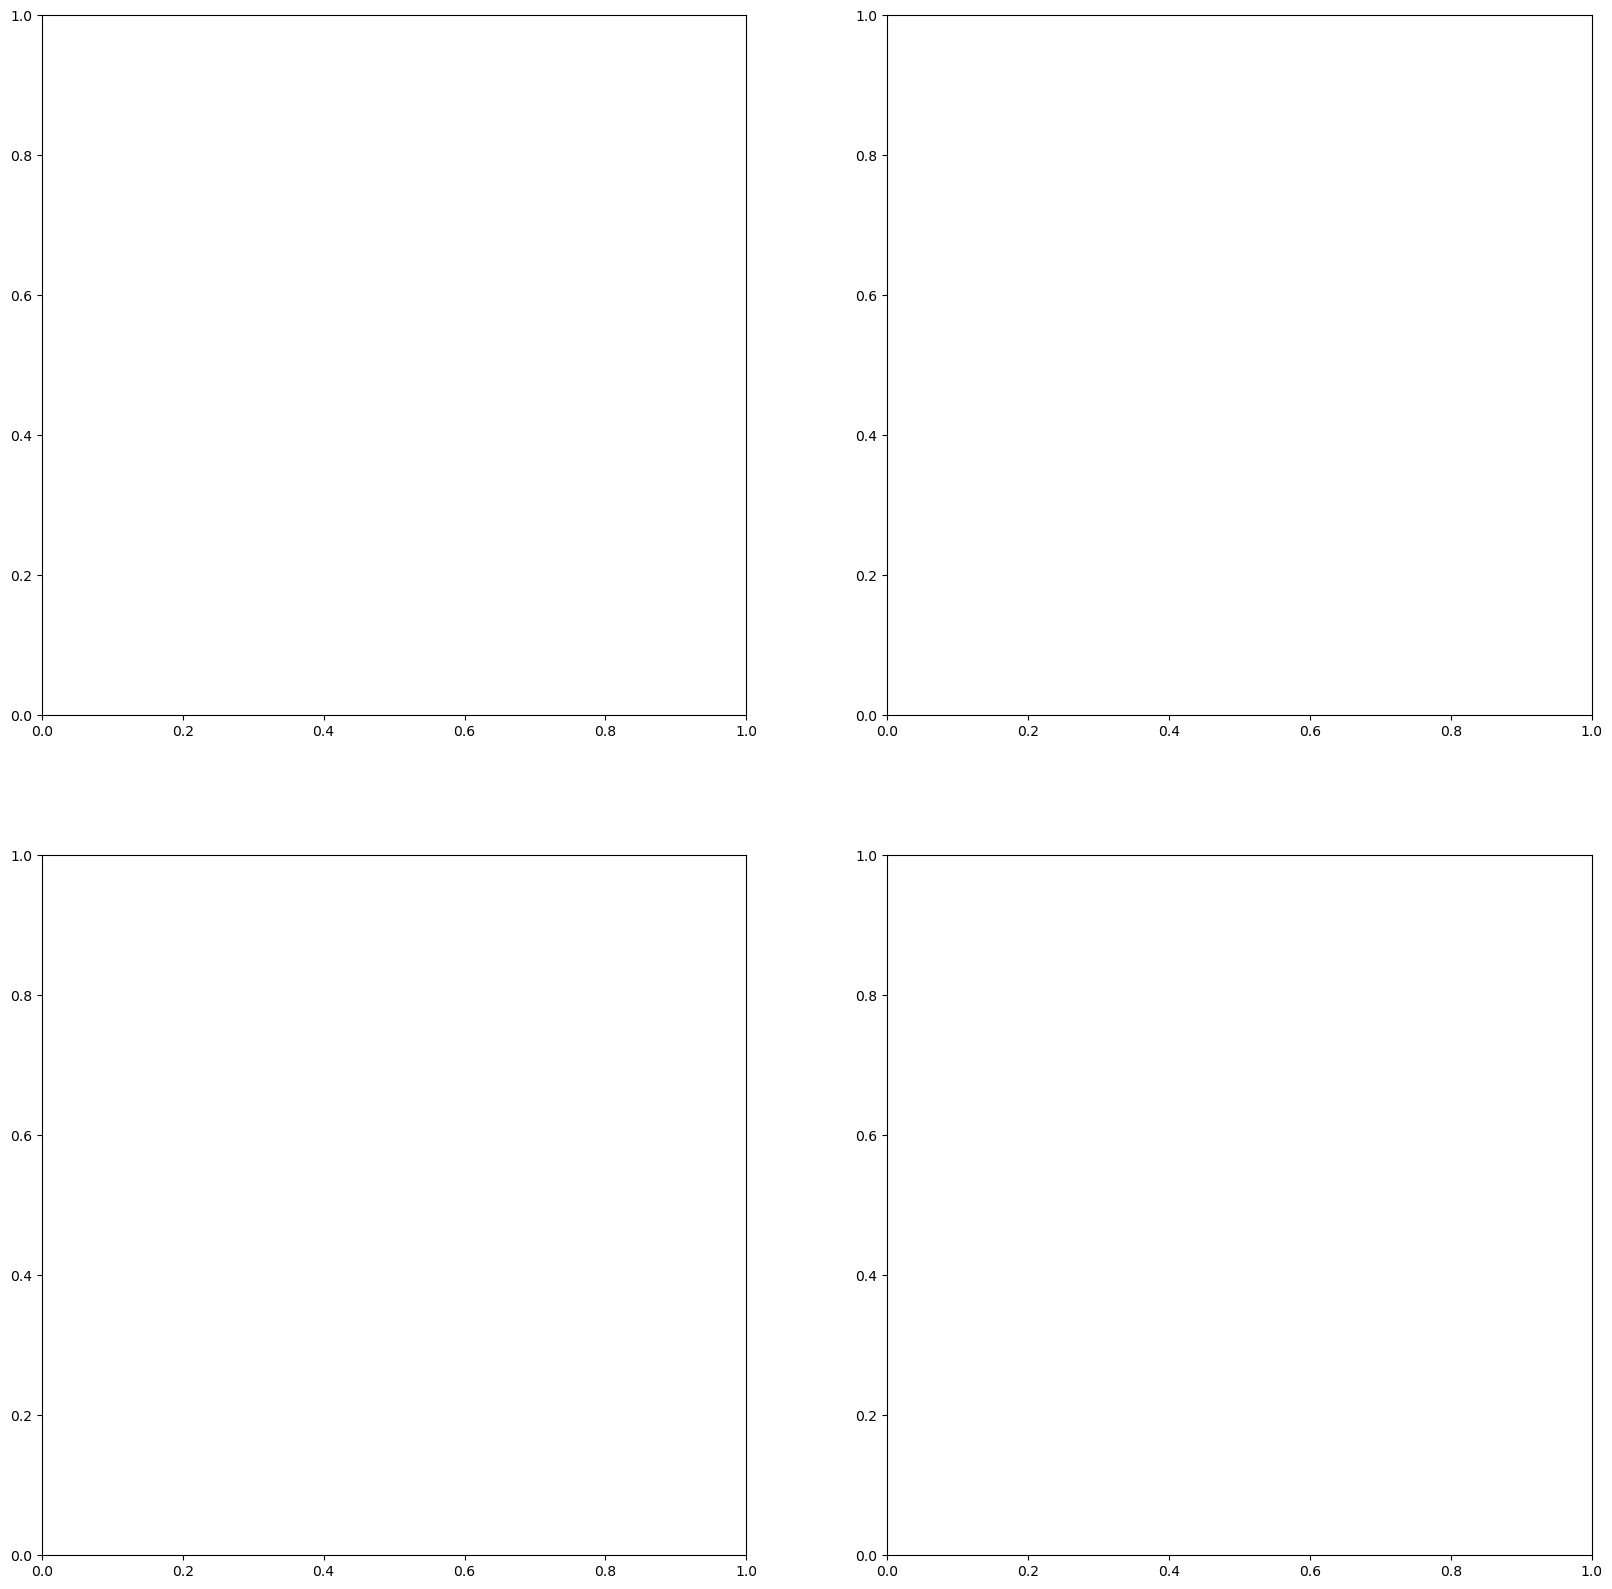

In [12]:
# plot average district size per state with alpha fairness
df_grp_state = df.groupby('State FIPS Code')
avg_by_state = df_grp_state['official_children_formula_count'].mean()
var_by_state = df_grp_state['official_children_formula_count'].var()
median_by_state = df_grp_state['official_children_formula_count'].median()
frac_poverty_by_state = df_grp_state['official_children_formula_count'].sum() / df_grp_state[
    'official_children_count'].sum()

df['frac_poverty'] = df['official_children_formula_count'] / df['official_children_count']
avg_district_frac_poverty_by_state = df_grp_state['frac_poverty'].mean()


# plot bias by some x arr
def plot_alpha_fairness_by_x(alloc, x, ax=None, xlabel=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    df[f'{alloc}_bias'] = df[f'avg_noisy_{alloc}_alloc'] - df[f'calculated_{alloc}_alloc']
    bias = df_grp_state[f'{alloc}_bias']
    print(bias.argmax())
    alpha_fairness = (bias.max() - bias.min()) / total_funds[alloc]
    ax.scatter(list(x), list(alpha_fairness))
    ax.set_title(f'{alloc.capitalize()} Grant')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Alpha Fairness')
    # set logscale
    #ax.set_xscale('log')


allocs = ['basic', 'concentrated', 'targeted', 'total']
xs = [avg_by_state]
xlabels = ['Variance District Size']

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for i, alloc in enumerate(allocs):
    plot_alpha_fairness_by_x(alloc, xs[0], ax=axs[i // 2, i % 2], xlabel=xlabels[0])



In [13]:
# create an empty list to hold the names of numerical columns
numerical_cols = []

# loop through each column and check if it contains numerical data
for col in df.columns:
    if np.issubdtype(df[col].dtype, np.number):
        numerical_cols.append(col)

# calculate the correlation matrix for the numerical columns
corr_matrix = df[numerical_cols].corr()
corr_matrix.to_csv('/Users/pranavputta/Downloads/corr_matrix.csv')
corr_matrix

,State FIPS Code,District ID,basic_alloc,targeted_alloc,concentration_alloc,official_population_count,official_children_count,official_children_formula_count,saipe_population_count,saipe_children_count,...,concentrated_error,targeted_error,calculated_total_alloc,avg_noisy_total_alloc,official_children_formula_proportion,noisy_children_formula_proportion,total_alloc_error,total_alloc_error_per_student,frac_poverty,basic_bias
State FIPS Code,1.000000,0.059330,-0.027336,-0.020979,-0.026243,-0.053623,-0.032685,-0.027949,-0.059756,-0.036686,...,0.007930,0.005790,-0.022810,-0.022819,-0.041660,-0.057486,0.008186,-0.032979,-0.041660,-0.003064
District ID,0.059330,1.000000,0.006871,0.016263,0.008218,-0.008525,-0.013535,-0.006302,-0.041146,-0.044179,...,0.009084,-0.011728,0.011107,0.011117,-0.038317,-0.031666,-0.001098,-0.011030,-0.038317,-0.000211
basic_alloc,-0.027336,0.006871,1.000000,0.990505,0.994318,0.894214,0.901149,0.985845,0.901275,0.904603,...,-0.145991,-0.752677,0.996767,0.996761,0.102725,0.077795,-0.568503,-0.039111,0.102725,-0.055712
targeted_alloc,-0.020979,0.016263,0.990505,1.000000,0.989311,0.863457,0.869097,0.969634,0.872352,0.872847,...,-0.139624,-0.755473,0.996569,0.996571,0.092615,0.073642,-0.564199,-0.026020,0.092615,-0.047648
concentration_alloc,-0.026243,0.008218,0.994318,0.989311,1.000000,0.872016,0.877372,0.980114,0.874607,0.876047,...,-0.150215,-0.749610,0.994914,0.994906,0.129688,0.104598,-0.568259,-0.032445,0.129688,-0.050104
official_population_count,-0.053623,-0.008525,0.894214,0.863457,0.872016,1.000000,0.982156,0.915740,1.000000,0.981651,...,-0.131770,-0.660598,0.876523,0.876508,-0.004247,-0.023361,-0.504317,-0.051472,-0.004247,-0.062463
official_children_count,-0.032685,-0.013535,0.901149,0.869097,0.877372,0.982156,1.000000,0.928809,0.981551,0.999995,...,-0.133845,-0.664775,0.883832,0.883819,-0.000445,-0.020035,-0.507713,-0.051891,-0.000445,-0.059948
official_children_formula_count,-0.027949,-0.006302,0.985845,0.969634,0.980114,0.915740,0.928809,1.000000,0.920108,0.929392,...,-0.143100,-0.738765,0.980060,0.980056,0.111332,0.084819,-0.557688,-0.041011,0.111332,-0.053857
saipe_population_count,-0.059756,-0.041146,0.901275,0.872352,0.874607,1.000000,0.981551,0.920108,1.000000,0.981651,...,-0.119116,-0.624027,0.886225,0.886208,-0.008010,-0.027699,-0.462159,-0.053928,-0.008010,-0.060061
saipe_children_count,-0.036686,-0.044179,0.904603,0.872847,0.876047,0.981651,0.999995,0.929392,0.981651,1.000000,...,-0.120589,-0.624051,0.889039,0.889024,-0.004177,-0.024215,-0.462509,-0.054019,-0.004177,-0.056981


In [143]:
df.loc[df_grp_state.groups[6]]

,State FIPS Code,District ID,State,Name,basic_alloc,targeted_alloc,concentration_alloc,official_population_count,official_children_count,official_children_formula_count,...,avg_noisy_targeted_alloc,basic_error,concentrated_error,targeted_error,calculated_total_alloc,avg_noisy_total_alloc,official_children_formula_proportion,noisy_children_formula_proportion,total_alloc_error,total_alloc_error_per_student
643,6,1620,CALIFORNIA,ABC Unified School District,1.707608e+06,9.045730e+05,264735.374292,108331.0,17163.0,2177.0,...,8.884723e+05,-519.008591,0.000000,-1978.196676,2.538095e+06,2.535598e+06,0.126843,0.126807,-2497.205267,-1.147086
644,6,1650,CALIFORNIA,Acalanes Union High School District,1.239329e+05,0.000000e+00,0.000000,118736.0,5953.0,158.0,...,0.000000e+00,-977.472426,0.000000,0.000000,1.195810e+05,1.186036e+05,0.026541,0.026461,-977.472426,-6.186534
645,6,1680,CALIFORNIA,Ackerman Elementary School District,2.745350e+04,1.084248e+04,0.000000,2926.0,277.0,35.0,...,1.110807e+04,-601.199281,3554.786204,434.859523,3.716268e+04,4.055112e+04,0.126354,0.124869,3388.446446,96.812756
646,6,1,CALIFORNIA,Acton-Agua Dulce Unified School District,1.560928e+05,6.164727e+04,0.000000,12882.0,1879.0,199.0,...,6.033394e+04,-589.663422,0.000000,-350.868168,2.112964e+05,2.103558e+05,0.105907,0.105496,-940.531590,-4.726289
647,6,1710,CALIFORNIA,Adelanto Elementary School District,1.517786e+06,8.797393e+05,385138.103714,60637.0,7067.0,1935.0,...,8.637925e+05,-615.433724,-711.290200,-2211.972840,2.737042e+06,2.733503e+06,0.273808,0.273706,-3538.696764,-1.828784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,6,160,CALIFORNIA,Yosemite Unified School District,2.358814e+05,9.741362e+04,57745.362901,25051.0,2400.0,227.0,...,6.890556e+04,-467.692753,0.000000,-317.810441,2.410265e+05,2.402410e+05,0.094583,0.094330,-785.503194,-3.460366
1583,6,43380,CALIFORNIA,Yreka Union Elementary School District,2.361001e+05,1.441438e+05,59910.371689,9520.0,1016.0,301.0,...,1.422713e+05,-326.860211,-174.753061,377.997206,4.329436e+05,4.328200e+05,0.296260,0.295883,-123.616066,-0.410685
1584,6,43410,CALIFORNIA,Yreka Union High School District,1.443270e+05,7.016960e+04,36622.951464,17255.0,826.0,184.0,...,6.999282e+04,-350.580512,-148.587439,918.731141,2.469918e+05,2.474114e+05,0.222760,0.222116,419.563190,2.280235
1585,6,43470,CALIFORNIA,Yuba City Unified School District,2.001752e+06,1.123746e+06,507944.413787,75425.0,14209.0,2552.0,...,1.103744e+06,-497.207971,-850.820118,-2457.695089,3.573844e+06,3.570038e+06,0.179604,0.179566,-3805.723178,-1.491271


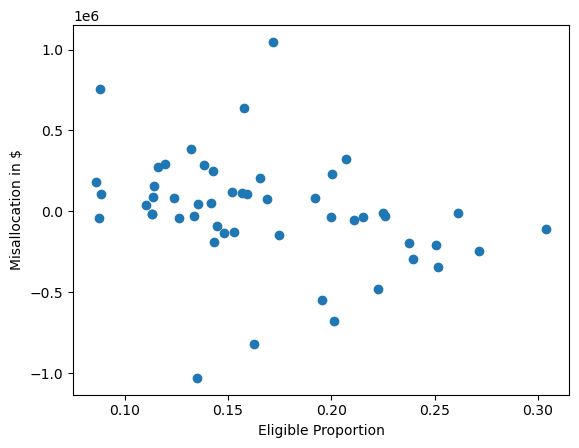

In [14]:
def plot_errors_by_x(alloc, x, log_scale=True, average=False, xlabel='Eligible Population'):
    df_state_by_state = {'errors': [], 'x': []}
    for key in list(df_grp_states.groups.keys()):
        df_state = df.loc[df_grp_states.groups[key]]
        errors = df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc']

        df_state_by_state['errors'].append(errors.sum())
        df_state_by_state['x'].append(df_state[x].sum() / (1 if not average else len(df_state)))

    plt.scatter(df_state_by_state['x'], df_state_by_state['errors'])
    if log_scale:
        plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel('Misallocation in $')
    # plt.legend()
    plt.show()


plot_errors_by_x('total', 'official_children_formula_proportion', log_scale=False, average=True,
                 xlabel='Eligible Proportion')

In [15]:
alloc = 'total'
df_state_by_state = {'errors': [], 'x': []}
for key in list(df_grp_states.groups.keys()):
    df_state = df.loc[df_grp_states.groups[key]]
    errors = df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc']

    alpha_fairness = (max(errors) - min(errors)) / total_funds[alloc]
    df_state_by_state['errors'].append(alpha_fairness)
    df_state_by_state['x'].append((df_state['official_children_count'].sum()))

plt.scatter(df_state_by_state['x'], df_state_by_state['errors'])
# plt.xscale('log')
plt.xlabel('Number of Students in State')
plt.ylabel('Misallocation in $')
# plt.legend()
plt.show()


NameError: name 'total_funds' is not defined

In [16]:
_tmp = df[df['State'] == 'TEXAS']
e = np.abs(_tmp['avg_noisy_total_alloc'] - _tmp['calculated_total_alloc'])
_tmp['total_errors'] = e
_tmp = _tmp[e > 1000]
_tmp[['official_children_formula_count', 'official_children_count', 'calculated_basic_alloc', 'avg_noisy_basic_alloc',
      'calculated_concentrated_alloc', 'avg_noisy_concentration_alloc', 'calculated_targeted_alloc',
      'avg_noisy_target_alloc', 'calculated_total_alloc', 'avg_noisy_total_alloc', 'total_errors']].sort_values(
    by='official_children_count')


/var/folders/_0/j0skcttj3nx9079xgvyy1gt00000gn/T/ipykernel_47391/1661208037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp['total_errors'] = e


,official_children_formula_count,official_children_count,calculated_basic_alloc,avg_noisy_basic_alloc,calculated_concentrated_alloc,avg_noisy_concentration_alloc,calculated_targeted_alloc,avg_noisy_target_alloc,calculated_total_alloc,avg_noisy_total_alloc,total_errors
11948,3.0,3.0,0.000000e+00,4.147748e+03,5.172358e+02,1.397605e+03,0.000000e+00,6.141879e+03,5.172358e+02,1.168723e+04,11169.995776
12062,4.0,12.0,0.000000e+00,4.401017e+03,6.896478e+02,1.455799e+03,0.000000e+00,6.117659e+03,6.896478e+02,1.197448e+04,11284.828244
11522,1.0,13.0,0.000000e+00,3.375101e+03,0.000000e+00,1.153239e+03,0.000000e+00,4.647237e+03,0.000000e+00,9.175577e+03,9175.576512
11492,2.0,13.0,0.000000e+00,3.782198e+03,3.448239e+02,1.271375e+03,0.000000e+00,5.210019e+03,3.448239e+02,1.026359e+04,9918.767909
11806,4.0,22.0,0.000000e+00,4.357728e+03,6.896478e+02,1.419069e+03,0.000000e+00,5.557168e+03,6.896478e+02,1.133397e+04,10644.317624
...,...,...,...,...,...,...,...,...,...,...,...
11162,14577.0,103519.0,9.053363e+06,9.052791e+06,2.513249e+06,2.509748e+06,7.767695e+06,7.752609e+06,1.933431e+07,1.931515e+07,19158.747000
11798,16521.0,110020.0,1.026073e+07,1.026007e+07,2.848418e+06,2.844447e+06,8.983880e+06,8.966426e+06,2.209302e+07,2.207094e+07,22085.828321
11350,16206.0,120145.0,1.006509e+07,1.006462e+07,2.794108e+06,2.790263e+06,8.786813e+06,8.769924e+06,2.164601e+07,2.162481e+07,21199.686695
11353,50220.0,193595.0,3.119022e+07,3.118908e+07,8.658528e+06,8.646697e+06,3.190710e+07,3.184612e+07,7.175585e+07,7.168190e+07,73949.750808


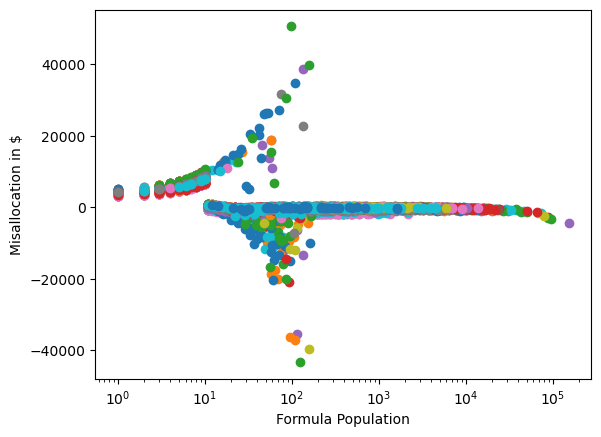

,State FIPS Code,District ID,State,Name,basic_alloc,targeted_alloc,concentration_alloc,official_population_count,official_children_count,official_children_formula_count,...,targeted_error,calculated_total_alloc,avg_noisy_total_alloc,official_children_formula_proportion,noisy_children_formula_proportion,total_alloc_error,total_alloc_error_per_student,frac_poverty,basic_bias,errors


In [17]:
def interpolate_colors(start_color, end_color, num_steps):
    # Convert the start and end colors to RGB tuples
    start_rgb = tuple(int(start_color[i:i + 2], 16) for i in (0, 2, 4))
    end_rgb = tuple(int(end_color[i:i + 2], 16) for i in (0, 2, 4))

    # Compute the step size for each color channel
    step_size = [int((end - start) / (num_steps - 1)) for start, end in zip(start_rgb, end_rgb)]

    # Yield the interpolated colors
    for i in range(num_steps):
        # Compute the color values for this step
        r = start_rgb[0] + step_size[0] * i
        g = start_rgb[1] + step_size[1] * i
        b = start_rgb[2] + step_size[2] * i

        # Yield the color as a hex string
        yield "#{:02x}{:02x}{:02x}".format(r, g, b)


colors = interpolate_colors("0000ff", "ff0000", 50)
for key in list(df_grp_states.groups.keys())[:]:
    df_state = df.loc[df_grp_states.groups[key]]
    errors = df_state['avg_noisy_basic_alloc'] - df_state['calculated_basic_alloc']
    df_state['errors'] = errors
    plt.scatter(df_state['official_children_formula_count'], errors, label=df_state['State'].iloc[0])
plt.xscale('log')
plt.xlabel('Formula Population')
plt.ylabel('Misallocation in $')
# plt.legend()
plt.show()

(df_state[(errors.abs() > 2500) & (df_state['official_children_formula_count'] > 10)])



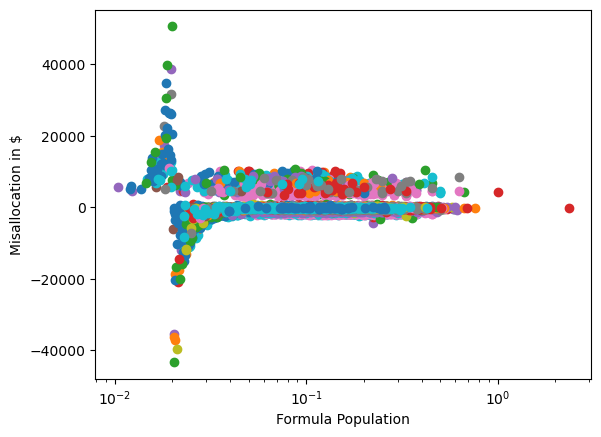

,State FIPS Code,District ID,State,Name,basic_alloc,targeted_alloc,concentration_alloc,official_population_count,official_children_count,official_children_formula_count,...,targeted_error,calculated_total_alloc,avg_noisy_total_alloc,official_children_formula_proportion,noisy_children_formula_proportion,total_alloc_error,total_alloc_error_per_student,frac_poverty,basic_bias,errors


In [18]:
# plot misallocation by fraction of population that is in poverty
for key in list(df_grp_states.groups.keys())[:]:
    df_state = df.loc[df_grp_states.groups[key]]
    errors = df_state['avg_noisy_basic_alloc'] - df_state['calculated_basic_alloc']
    frac_poverty = df_state['official_children_formula_count'] / df_state['official_children_count']
    df_state['errors'] = errors
    plt.scatter(frac_poverty, errors, label=df_state['State'].iloc[0])
plt.xscale('log')
plt.xlabel('Formula Population')
plt.ylabel('Misallocation in $')
# plt.legend()
plt.show()

(df_state[(errors.abs() > 2500) & (df_state['official_children_formula_count'] > 10)])



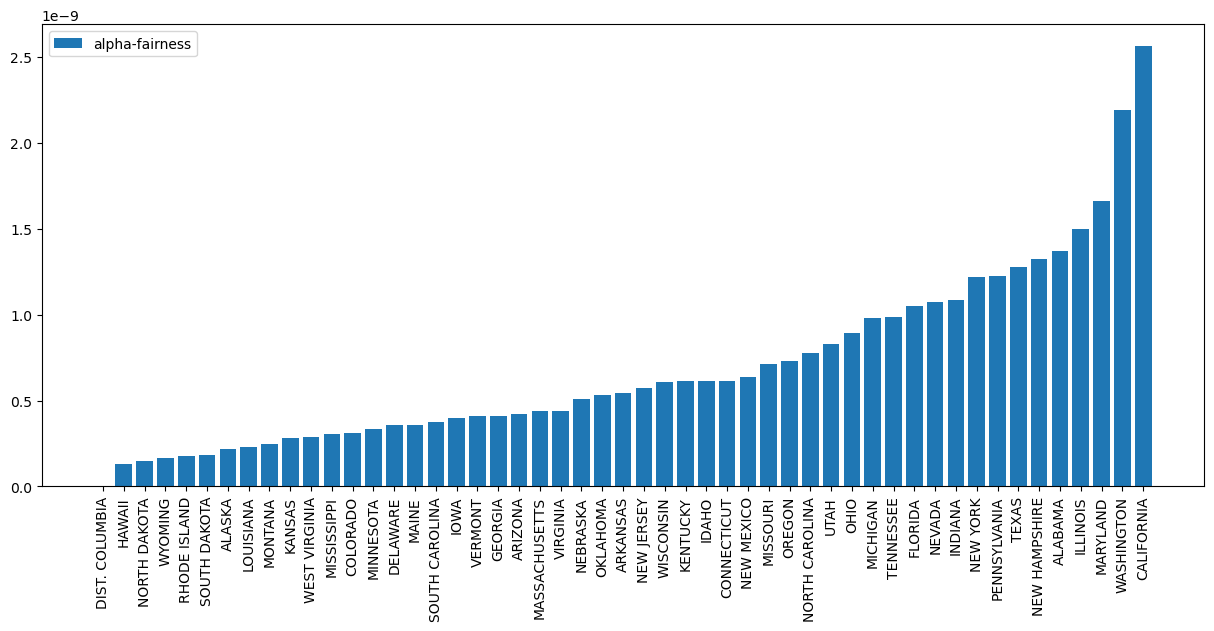

In [57]:

from collections import defaultdict
from titlei_util import *

def get_sppe(path):
    fips_codes = pd.read_csv(f"datasets/fips_codes.csv").rename(
        columns={
            'FIPS': 'State FIPS Code'
        }
    )
    # quirk of original data file - need to change DC's name for join
    fips_codes.loc[fips_codes["Name"] == "District of Columbia", "Name"] = \
        "District Of Columbia Public Schools"
    sppe = pd.read_excel(path, header=2, engine='openpyxl') \
        .rename(columns={"Unnamed: 0": "Name"})[["Name", "ppe"]]
    return sppe.merge(fips_codes, on="Name", how="right") \
        .set_index("State FIPS Code")

sppe = (get_sppe('datasets/sppe18.xlsx'))


# compute alpha fairness

stats_by_state = defaultdict(lambda: [].copy())
total_funds = {
    'basic': df['basic_alloc'].sum(),
    'concentrated': df['concentration_alloc'].sum(),
    'targeted': df['targeted_alloc'].sum()
}
total_funds['total'] = total_funds['basic'] + total_funds['concentrated'] + total_funds['targeted']
for key in df_grp_states.groups.keys():
    for alloc in ['total']:
        # s = sppe[key]
        df_state = df.loc[df_grp_states.groups[key]]
        bias = (df_state[f'avg_noisy_{alloc}_alloc'] - df_state[f'calculated_{alloc}_alloc'])  / (df_state['sppe'])# * df_state['official_children_formula_count'])
        # drop nans and infs
        bias = bias[~bias.isin([np.nan, np.inf, -np.inf])]
        alpha_fairness = (max(bias) - min(bias)) / total_funds[alloc]
        total_children_population = sum(df_state['official_children_count'])
        formula_children_population = sum(df_state['official_children_formula_count'])
        total_population = sum(df_state['official_population_count'])

        stats_by_state['alpha_fairness'].append(alpha_fairness)
        stats_by_state['children_population'].append(total_children_population)
        stats_by_state['children_formula_population'].append(formula_children_population)
        stats_by_state['total_population'].append(total_population)
        stats_by_state['state'].append(df_state['State'].iloc[0])

stats_by_state_df = pd.DataFrame(stats_by_state)

# plot histogram
stats_by_state_df = stats_by_state_df.sort_values(by=['alpha_fairness'])
plt.figure(figsize=(15, 6))
plt.bar(stats_by_state_df['state'], stats_by_state_df['alpha_fairness'], label='alpha-fairness')
# plt.title('Basic')
plt.xticks(rotation=90)
plt.legend()
plt.show()




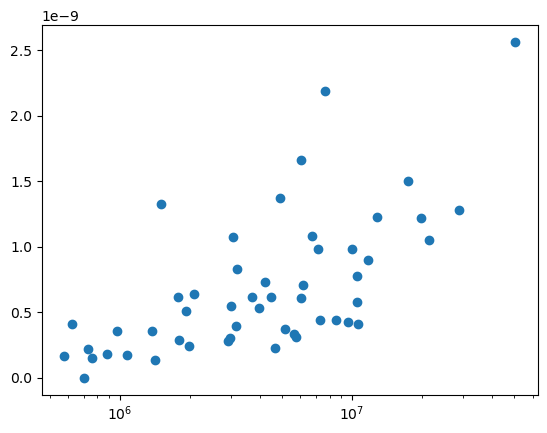

In [58]:
plt.scatter(stats_by_state_df['total_population'], stats_by_state_df['alpha_fairness'])
plt.xscale('log')


/var/folders/_0/j0skcttj3nx9079xgvyy1gt00000gn/T/ipykernel_47391/3855443777.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info, shrink=0.5)


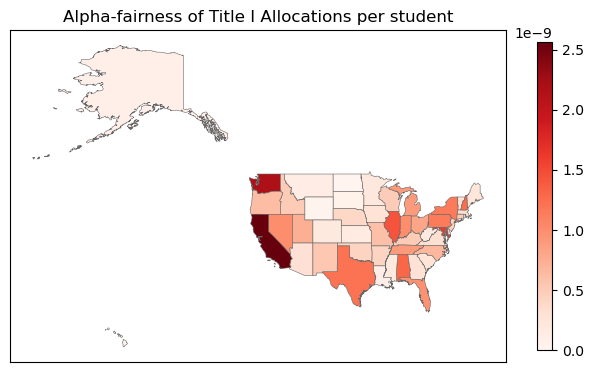

In [59]:
import geopandas as gpd

usa = gpd.read_file('data_viz/states.shp')
usa['state'] = usa['state_name'].str.upper()
usa = usa.merge(stats_by_state_df, on='state')

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks([])
plt.yticks([])

values = stats_by_state_df['alpha_fairness']

usa.plot(column="alpha_fairness", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
#
bar_info = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=np.min(values), vmax=np.max(values)))
bar_info._A = []
#make colorbar smaller
cbar = fig.colorbar(bar_info, shrink=0.5)
plt.title('Alpha-fairness of Title I Allocations per student')
plt.show()


In [ ]:
usa.keys()

In [46]:
from titlei_util import *

def get_sppe(path):
    fips_codes = pd.read_csv(f"datasets/fips_codes.csv").rename(
        columns={
            'FIPS': 'State FIPS Code'
        }
    )
    # quirk of original data file - need to change DC's name for join
    fips_codes.loc[fips_codes["Name"] == "District of Columbia", "Name"] = \
        "District Of Columbia Public Schools"
    sppe = pd.read_excel(path, header=2, engine='openpyxl') \
        .rename(columns={"Unnamed: 0": "Name"})[["Name", "ppe"]]
    return sppe.merge(fips_codes, on="Name", how="right") \
        .set_index("State FIPS Code")

sppe = (get_sppe('datasets/sppe18.xlsx'))


In [47]:
sppe

,Name,ppe,Postal Code
State FIPS Code,,,
1,Alabama,9697,AL
2,Alaska,17726,AK
4,Arizona,8296,AZ
5,Arkansas,10072,AR
6,California,12510,CA
8,Colorado,10157,CO
9,Connecticut,19939,CT
10,Delaware,15289,DE
11,District Of Columbia Public Schools,22759,DC
